# README Prophesy
By Nicole Garza & Michael P. Moran

  ## Table of contents
1. [Project Planning](#project-planning)
1. [Acquisition](#acquisition)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)

## Project Planning <a name="project-planning"></a>

### Goals

A model that predicts the predominant language of a GitHub repo given the repo's README file

### Deliverables

* Jupyter notebook containing analysis
* One or two google slides suitable for a general audience that summarize findings. Include a well-labelled visualization in your slides.
* A function taking a README as input and outputting the language

### Project Conclusions

* Acquisition
    * Acquiring the data was challenging. We had two main options: (1) scrape the HTML-rendered search results and (2) use the JSON API. We chose to use the JSON API because it allowed dictionary-based access to the information we needed. We did not have to identify the correct HTML tag or do anything else associated with scraping. The JSON API also allowed us to download many more repos faster than scraping the HTML.
    * We also had the choice of scraping the HTML rendered README or downloading the raw README file. Acquiring the raw README was significantly easier, so we chose this. However, GitHub's API only returns a raw README file, not the rendered HTML version (although it's available in a link).
* Preparation
    * We processed the raw README using a markdown module, which rendered it to HTML. We then used Beautiful Soup to extract the text. We removed single character words (which was pointless because the sklearn vectorizers do this already) and also removed links.
    * We also removed non-English repos given that we are ASCII normalizing. Thus, our model is for English repos only. We dropped repos with no programming language, so our model has this limitation.
* Exploration
    * The most common languages were JavaScript, Java, Python, C++, and HTML. JavaScript and Java are heavily overrepresented. If we had more time, we would have rebalanced the dataset, so they do not predominate.
    * The most common words look like generic programming terms ("use", "code", "file") and do not appear to be useful indicators of the language (except for JavaScript, which we hope would indicate JavaScript). Also, there is significant overlap of the most common bigrams for the languages. Thus, bigrams may not perform better than single words.
    * We have problems with runon words. If we had more time, this is something to address.
* Modeling
    * Our model predicts for only the top 5 most common repos. Thus, an input repo that is not predominately programmed in one of these languages will automatically be wrong. We tried to use an "other" category but this sorely hurt our models' performance. Accuracy plummeted about 20-30 percentage points on average. It may be because "other" had such diversity of language it was pulling in repos it shouldn't. We tried using bigrams, but these did not give us better predictive power, which was not expected. The bigrams appeared to be unique overall to the individual languages.
    * We also used lemmatized, stemmed, and clean version of the README. Clean appeared to perform on par with stemmed. Not really sure why at this time.
    * With more time, we would add the number of words in the README as a feature.
    * KNN and Random Forest give us our best results

### Data Dictionary & Domain Knowledge

### Hypotheses
* The primary language may be mentioned in the README. But some repositories mention multiple languages, so this may interfere with this method.
* The number of words may be an indication of the language. Older repositories are probably written in certain languages and because of their age, may have more documentation.

### Thoughts & Questions

* The code in many repositories are written in multiple languages. We will go with the most predominant language.
* Take out repos with no programming language
* After taking out the "Other" programming language category, the accuracy of the model shot way up! I believe this category acquired so much language that was used in the top5 repos the models were having difficulty choosing the class.


### Prepare the Environment

In [1]:
import os
import json
from pprint import pprint
import re
import unicodedata
from functools import reduce, partial
from copy import deepcopy
from markdown import markdown
import pickle

import requests
from bs4 import BeautifulSoup
import pandas as pd

import env

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from langdetect import detect

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Acquisition <a name="acquisition"></a>

**Grab data for 1000 most forked repos on GitHub**

**Constants**

In [2]:
NUM_PER_PAGE = 50
PAGES = 20
API_URL = f"https://api.github.com/search/repositories?q=stars:%3E1&sort=forks&order=desc&per_page={NUM_PER_PAGE}"
HEADERS = {"Authorization": f"token {env.oauth_token}"}
REPO_FILE_NAME = "repos.json"

**Download the data or read from repos.json file**

In [3]:
def github_api_req(page):
    data = requests.get(API_URL + f"&page={page}", headers=HEADERS).json()
    return data["items"]


def readme_url(contents_url):
    # find name of README file and construct a link to the raw text of the readme
    for file in requests.get(contents_url, headers=HEADERS).json():
        if file["name"].lower().startswith("readme"):
            return file["download_url"]


def load_repo_metadata(use_cache=True):
    if use_cache and os.path.exists(REPO_FILE_NAME):
        with open(REPO_FILE_NAME, "r") as f:
            contents = json.load(f)
        return contents
    else:
        response = []
        for num in range(1, PAGES + 1):
            response += github_api_req(num)
        for repo in response:
            # get link to contents of repo
            contents_url = repo["contents_url"][
                :-8
            ]  # remove last 8 characters to get working URL

            rmurl = readme_url(contents_url)

            readme_text = None  # sometimes there is no valid URL to the readme
            if rmurl:
                # download README text
                readme_text = requests.get(rmurl, headers=HEADERS).text

            repo["readme"] = readme_text
        with open(REPO_FILE_NAME, "w") as f:
            json.dump(response, f)
        return response


all_repo_data = load_repo_metadata()

In [4]:
all_repo_data[:3]

[{'id': 14204342,
  'node_id': 'MDEwOlJlcG9zaXRvcnkxNDIwNDM0Mg==',
  'name': 'datasharing',
  'full_name': 'jtleek/datasharing',
  'private': False,
  'owner': {'login': 'jtleek',
   'id': 1571674,
   'node_id': 'MDQ6VXNlcjE1NzE2NzQ=',
   'avatar_url': 'https://avatars2.githubusercontent.com/u/1571674?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/jtleek',
   'html_url': 'https://github.com/jtleek',
   'followers_url': 'https://api.github.com/users/jtleek/followers',
   'following_url': 'https://api.github.com/users/jtleek/following{/other_user}',
   'gists_url': 'https://api.github.com/users/jtleek/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/jtleek/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/jtleek/subscriptions',
   'organizations_url': 'https://api.github.com/users/jtleek/orgs',
   'repos_url': 'https://api.github.com/users/jtleek/repos',
   'events_url': 'https://api.github.com/users/jtleek/events{/privac

## Preparation <a name="preparation"></a>

In [5]:
def all_repo_metadata(api_data):
    return [
        repo_metadata(repo) for repo in api_data if repo["readme"] is not None
    ]


def repo_metadata(api_dict):
    # store the id, username, name of repo
    repo_id = api_dict["id"]
    user_name = api_dict["owner"]["login"]
    repo_name = api_dict["name"]

    # find the predominant programming language
    lang = api_dict["language"]

    # render the markdown to html
    html = markdown(api_dict["readme"])
    # and extract the text from the html
    soup = BeautifulSoup(html, "html.parser")
    readme_text = soup.text

    return dict(
        repo_id=repo_id,
        user_name=user_name,
        repo_name=repo_name,
        lang=lang,
        readme=readme_text,
    )


some_repo_data = all_repo_metadata(all_repo_data)

In [6]:
some_repo_data[:3]

[{'repo_id': 14204342,
  'user_name': 'jtleek',
  'repo_name': 'datasharing',
  'lang': None,
  'readme': 'How to share data with a statistician\nThis is a guide for anyone who needs to share data with a statistician or data scientist. The target audiences I have in mind are:\n\nCollaborators who need statisticians or data scientists to analyze data for them\nStudents or postdocs in various disciplines looking for consulting advice\nJunior statistics students whose job it is to collate/clean/wrangle data sets\n\nThe goals of this guide are to provide some instruction on the best way to share data to avoid the most common pitfalls\nand sources of delay in the transition from data collection to data analysis. The Leek group works with a large\nnumber of collaborators and the number one source of variation in the speed to results is the status of the data\nwhen they arrive at the Leek group. Based on my conversations with other statisticians this is true nearly universally.\nMy strong fee

**Clean, stem, lemmatize, and remove stopwords**

In [7]:
# right to left
def compose(*fns):
    return partial(reduce, lambda x, f: f(x), reversed(fns))


# applies in the order supplied
def pipe(v, *fns):
    return reduce(lambda x, f: f(x), fns, v)


def map_exhaust(func, *iters):
    for args in zip(*iters):
        func(*args)


def normalize_text(text):
    return (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )


def remove_chars(text):
    return re.sub(r"[^A-Za-z0-9 ]", "", re.sub(r"\s", " ", text))


def remove_bogus_words(text):
    no_single_words = re.sub(r"\s.{1}\s", "", text)  # remove single characters
    return re.sub(r"http.{1,}[\s\.]*", "", no_single_words)  # remove links


def basic_clean(text):
    return pipe(text, str.lower, normalize_text, remove_chars)


def tokenize(text):
    tokenizer = ToktokTokenizer()
    return tokenizer.tokenize(text, return_str=True)


def stem(text):
    ps = nltk.porter.PorterStemmer()
    return " ".join([ps.stem(word) for word in text.split()])


def lemmatize(text):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in text.split()]
    return " ".join(lemmas)


def remove_stopwords(text, include=[], exclude=[]):
    stopword_list = stopwords.words("english")

    map_exhaust(stopword_list.remove, exclude)
    map_exhaust(stopword_list.append, include)

    removed = " ".join([w for w in text.split() if w not in stopword_list])

    #     print("Removed", len(text.split()) - len(removed.split()), "words")
    return removed


def prep_readme(repo_data):
    copy = deepcopy(repo_data)

    copy["clean"] = pipe(
        copy["readme"],
        basic_clean,
        tokenize,
        remove_stopwords,
        remove_bogus_words,
    )

    copy["stemmed"] = stem(copy["clean"])

    copy["lemmatized"] = lemmatize(copy["clean"])

    return copy


def prep_readme_data(all_repo_data):
    return [prep_readme(repo) for repo in all_repo_data]


df = pd.DataFrame(prep_readme_data(some_repo_data))

any single j's?

In [8]:
df[df.clean.str.contains(" j ")]

Empty DataFrame
Columns: [clean, lang, lemmatized, readme, repo_id, repo_name, stemmed, user_name]
Index: []

any links?

In [9]:
df[df.clean.str.contains(" http")]

Empty DataFrame
Columns: [clean, lang, lemmatized, readme, repo_id, repo_name, stemmed, user_name]
Index: []

### Summarize Data

In [10]:
df.head()

clean        lang  \
0  share data statistician guide anyone needs sha...        None   
1  introduction second programming assignment req...           R   
2  well hello repository meant provide example fo...        HTML   
3  documentation tensorflow open source software ...         C++   
4  bootstrap sleek intuitive powerful frontend fr...  JavaScript   

                                          lemmatized  \
0  share data statistician guide anyone need shar...   
1  introduction second programming assignment req...   
2  well hello repository meant provide example fo...   
3  documentation tensorflow open source software ...   
4  bootstrap sleek intuitive powerful frontend fr...   

                                              readme   repo_id  \
0  How to share data with a statistician\nThis is...  14204342   
1  Introduction\nThis second programming assignme...  15917132   
2  Well hello there!\nThis repository is meant to...   1300192   
3  \n\n\n\n| Documentation |\n|-----------------|...  45717250   
4  \n\n\n\n\nBootstrap\n\n  Sleek, intuitive, and...   2126244   

                repo_name                                            stemmed  \
0             datasharing  share data statistician guid anyon need share ...   
1  ProgrammingAssignment2  introduct second program assign requir writefu...   
2             Spoon-Knife  well hello repositori meant provid exampl fork...   
3              tensorflow  document tensorflow open sourc softwar librari...   
4               bootstrap  bootstrap sleek intuit power frontend framewor...   

    user_name  
0      jtleek  
1      rdpeng  
2     octocat  
3  tensorflow  
4        twbs

In [11]:
df.describe(include="all")

clean        lang lemmatized  \
count    994         881        994   
unique   965          43        964   
top           JavaScript              
freq       9         242          9   
mean     NaN         NaN        NaN   
std      NaN         NaN        NaN   
min      NaN         NaN        NaN   
25%      NaN         NaN        NaN   
50%      NaN         NaN        NaN   
75%      NaN         NaN        NaN   
max      NaN         NaN        NaN   

                                                   readme       repo_id  \
count                                                 994  9.940000e+02   
unique                                                977           NaN   
top     Generated files\nThis repository contains gene...           NaN   
freq                                                    5           NaN   
mean                                                  NaN  3.232594e+07   
std                                                   NaN  3.610520e+07   
min                                                   NaN  3.314000e+03   
25%                                                   NaN  3.747378e+06   
50%                                                   NaN  2.013301e+07   
75%                                                   NaN  4.895340e+07   
max                                                   NaN  1.777365e+08   

       repo_name stemmed user_name  
count        994     994       994  
unique       965     964       756  
top      Arduino           udacity  
freq           4       9        19  
mean         NaN     NaN       NaN  
std          NaN     NaN       NaN  
min          NaN     NaN       NaN  
25%          NaN     NaN       NaN  
50%          NaN     NaN       NaN  
75%          NaN     NaN       NaN  
max          NaN     NaN       NaN

In [12]:
df.lang.value_counts(dropna=False)

JavaScript                  242
Java                        137
NaN                         113
Python                       91
HTML                         46
C++                          45
Ruby                         36
Go                           31
C                            30
PHP                          29
Jupyter Notebook             26
CSS                          26
Shell                        19
Objective-C                  19
C#                           17
TypeScript                   15
Swift                        12
Kotlin                        9
Vue                           7
Scala                         5
TeX                           5
PowerShell                    4
Vim script                    3
Lua                           3
Groovy                        2
Makefile                      2
Rust                          2
R                             2
Batchfile                     1
Julia                         1
VimL                          1
Assembly

### Remove repos that have one or fewer words

In [13]:
print("Before removal:", len(df))
df = df[df.clean.apply(lambda s: len(s.split()) > 1)]
print("After removal:", len(df))

Before removal: 994
After removal: 962


### Remove Non-English Repos

**What does the language spread look like?**

In [14]:
df.clean.apply(detect).value_counts()

en    872
fr     28
ca      9
nl      7
af      6
it      5
cy      5
de      4
ro      4
et      4
es      3
pt      3
sv      2
vi      2
lt      1
no      1
sk      1
hr      1
sl      1
sq      1
cs      1
tl      1
Name: clean, dtype: int64

In [15]:
print("Before removal:", len(df))
df = df[df.clean.apply(detect) == "en"]
print("After removal:", len(df))

Before removal: 962
After removal: 873


### Check Missing Values

#### Remove repos that have no programming language

In [16]:
len(df)

873

In [17]:
df.isna().sum()

clean          0
lang          94
lemmatized     0
readme         0
repo_id        0
repo_name      0
stemmed        0
user_name      0
dtype: int64

In [18]:
df = df.dropna()

In [19]:
df.isna().sum()

clean         0
lang          0
lemmatized    0
readme        0
repo_id       0
repo_name     0
stemmed       0
user_name     0
dtype: int64

In [20]:
len(df)

779

#### Most common languages

In [21]:
langs = pd.concat(
    [df.lang.value_counts(dropna=False), df.lang.value_counts(dropna=False, normalize=True)], axis=1
)
langs.columns = ["n", "percent"]
langs

n   percent
JavaScript                219  0.281130
Java                      113  0.145058
Python                     75  0.096277
C++                        43  0.055199
HTML                       36  0.046213
Ruby                       33  0.042362
Go                         29  0.037227
C                          28  0.035944
PHP                        27  0.034660
CSS                        24  0.030809
Jupyter Notebook           24  0.030809
Shell                      17  0.021823
C#                         17  0.021823
Objective-C                16  0.020539
TypeScript                 13  0.016688
Swift                      10  0.012837
Kotlin                      9  0.011553
Vue                         5  0.006418
Scala                       5  0.006418
TeX                         4  0.005135
PowerShell                  4  0.005135
Lua                         3  0.003851
R                           2  0.002567
Groovy                      2  0.002567
Makefile                    2  0.002567
Rust                        2  0.002567
Vim script                  2  0.002567
Apex                        1  0.001284
Objective-C++               1  0.001284
Smarty                      1  0.001284
Rascal                      1  0.001284
VimL                        1  0.001284
Batchfile                   1  0.001284
Julia                       1  0.001284
Emacs Lisp                  1  0.001284
Dockerfile                  1  0.001284
WebAssembly                 1  0.001284
ApacheConf                  1  0.001284
Nix                         1  0.001284
Dart                        1  0.001284
DIGITAL Command Language    1  0.001284
CoffeeScript                1  0.001284

**Go with top 5 languages and roll the rest into an "other" category**

In [22]:
top_five = list(langs[:5].index)
pprint(top_five)

lang_grouped = df.lang.apply(
    lambda lang: lang if lang in top_five else "Other"
).rename("lang_grouped")

# pprint(lang_grouped)
df = pd.concat([df, lang_grouped], axis=1)

['JavaScript', 'Java', 'Python', 'C++', 'HTML']


In [23]:
df.lang_grouped.value_counts()

Other         293
JavaScript    219
Java          113
Python         75
C++            43
HTML           36
Name: lang_grouped, dtype: int64

### Ensure no missing values

In [24]:
df.isnull().sum()

clean           0
lang            0
lemmatized      0
readme          0
repo_id         0
repo_name       0
stemmed         0
user_name       0
lang_grouped    0
dtype: int64

## Exploration  <a name="exploration"></a>

### Extract words from readmes for top 5 languages and "Other"

In [25]:
top_six = df.lang_grouped.value_counts().index
words_by_lang = {}
for lang in top_six:
    words_by_lang[lang] = " ".join(df[df.lang_grouped == lang].stemmed)

**Series of all words and their frequencies**

In [26]:
words_by_freq = " ".join(df.stemmed)
words_by_freq = pd.Series(words_by_freq.split()).value_counts()
print("Top 5 most common words")
words_by_freq.head()

Top 5 most common words


use           2457
code          1185
instal        1035
file           914
javascript     847
dtype: int64

**Dictionary of top 5 languages + "other" and the frequency of their words**

In [27]:
word_freq_by_lang = {
    lang: pd.Series(words.split()).value_counts()
    for lang, words in words_by_lang.items()
}
pprint(word_freq_by_lang)

{'C++': cmedium                143
use                    136
ceasi                   86
build                   83
code                    74
releas                  71
instal                  69
window                  64
version                 60
pleas                   59
project                 58
chard                   56
test                    56
licens                  53
develop                 53
support                 52
apollo                  48
librari                 47
tree                    46
file                    44
xlog                    43
run                     43
see                     42
binari                  42
contribut               42
need                    40
chang                   39
new                     39
sourc                   37
python                  37
                      ... 
saf                      1
cize                     1
153find                  1
facehand                 1
packedsyncptrh           1
incorrect           

**Most frequent words overall and how they measure in top 5 languages + other**

In [28]:
top_words = (
    pd.concat(
        [words_by_freq] + list(word_freq_by_lang.values()), axis=1, sort=True
    )
    .set_axis(["all"] + list(word_freq_by_lang.keys()), axis=1, inplace=False)
    .fillna(0)
    .apply(lambda s: s.astype(int))
)

top_words.sort_values(by="all", ascending=False).head(5)

all  Other  JavaScript  Java  Python  C++  HTML
use         2457    936         786   275     248  136    76
code        1185    498         372   114      99   74    28
instal      1035    459         322    24     130   69    31
file         914    454         282    67      54   44    13
javascript   847     46         748     2      28    8    15

**And least frequent**

In [29]:
top_words.sort_values(by="all", ascending=False).tail(5)

all  Other  JavaScript  Java  Python  C++  HTML
hacktob     1      1           0     0       0    0     0
hadax       1      0           1     0       0    0     0
hadaxapi    1      0           1     0       0    0     0
haddix      1      1           0     0       0    0     0
zzztimbo    1      0           0     0       1    0     0

**Most common users**

In [30]:
df.user_name.value_counts().head(5)

udacity              17
learn-co-students    17
apache               16
facebook             12
google               11
Name: user_name, dtype: int64

**Top 5 words unique to top 5 languages**

In [31]:
unique_words_by_lang = pd.DataFrame()
for lang in top_words.drop(columns="all"):
    unique = top_words.drop(columns="all")[
        top_words[lang] == top_words.drop(columns=["all"]).sum(axis=1)
    ]
    unique_words_by_lang = pd.concat(
        [
            unique_words_by_lang,
            unique.sort_values(by=lang, ascending=False).head(5),
        ]
    )

In [32]:
unique_words_by_lang

Other  JavaScript  Java  Python  C++  HTML
marlin                  74           0     0       0    0     0
carthag                 39           0     0       0    0     0
penguin                 36           0     0       0    0     0
tvo                     33           0     0       0    0     0
hovercss                31           0     0       0    0     0
iscrol                   0          65     0       0    0     0
indexj                   0          55     0       0    0     0
automerg                 0          48     0       0    0     0
scrollbar                0          35     0       0    0     0
susan                    0          30     0       0    0     0
guava                    0           0    39       0    0     0
hystrix                  0           0    22       0    0     0
hive                     0           0    17       0    0     0
libgdx                   0           0    17       0    0     0
dubbo                    0           0    14       0    0     0
challengesolut           0           0     0     101    0     0
contributecontribut      0           0     0      29    0     0
starstarstarstar         0           0     0      27    0     0
airflow                  0           0     0      22    0     0
gensim                   0           0     0      20    0     0
cmedium                  0           0     0       0  143     0
ceasi                    0           0     0       0   86     0
chard                    0           0     0       0   56     0
xlog                     0           0     0       0   43     0
kodi                     0           0     0       0   32     0
gentelella               0           0     0       0    0    27
fastclick                0           0     0       0    0    20
fasttext                 0           0     0       0    0    12
zepto                    0           0     0       0    0     7
censu                    0           0     0       0    0     7

### Visualizations

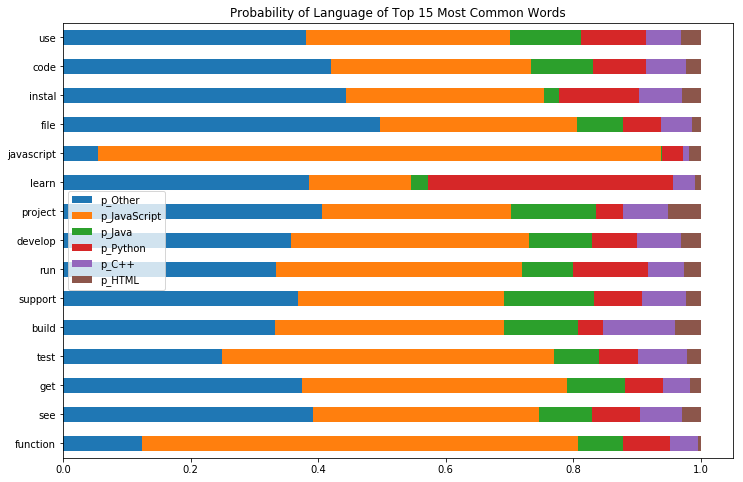

In [33]:
lang_prob = top_words[["all"]].copy()
for lang in top_words.drop(columns="all"):
    lang_prob[f"p_{lang}"] = top_words[lang] / top_words["all"]

lang_prob.sort_values(by="all").tail(15).drop(columns="all").plot.barh(
    stacked=True, figsize=(12, 8)
)
plt.title("Probability of Language of Top 15 Most Common Words")
plt.show()

Unsurprisingly, the most common words are representatively spread out among the categories

#### Word Cloud

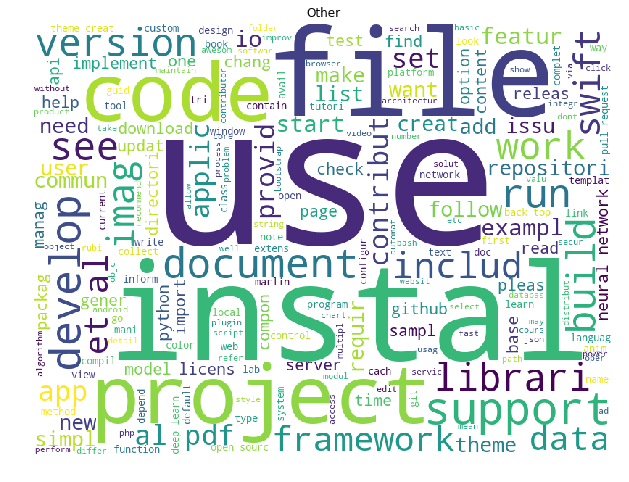

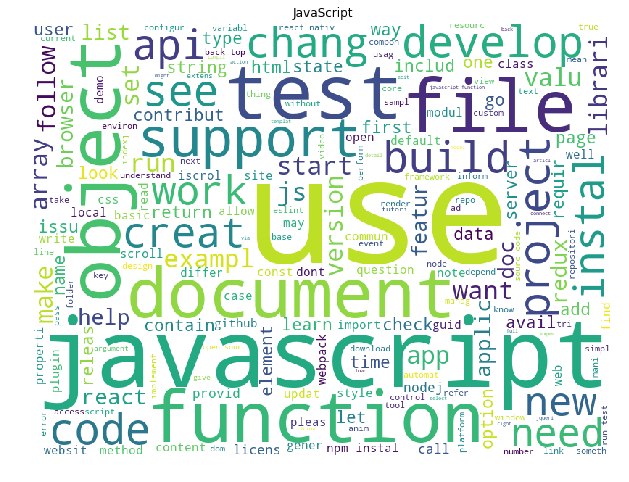

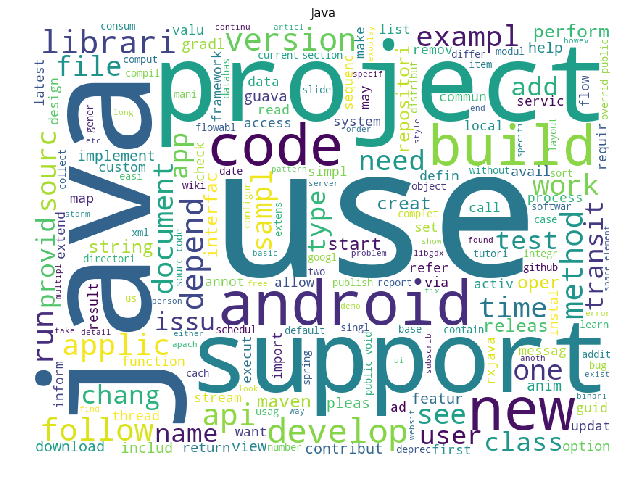

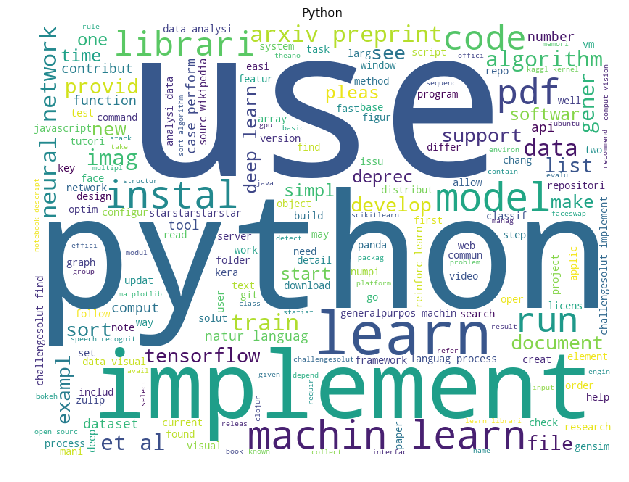

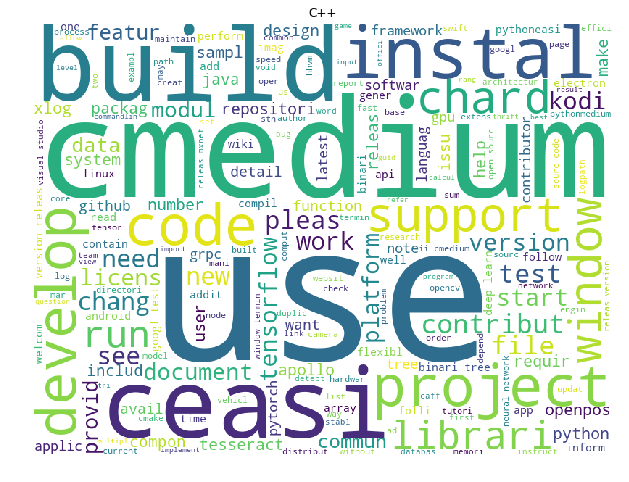

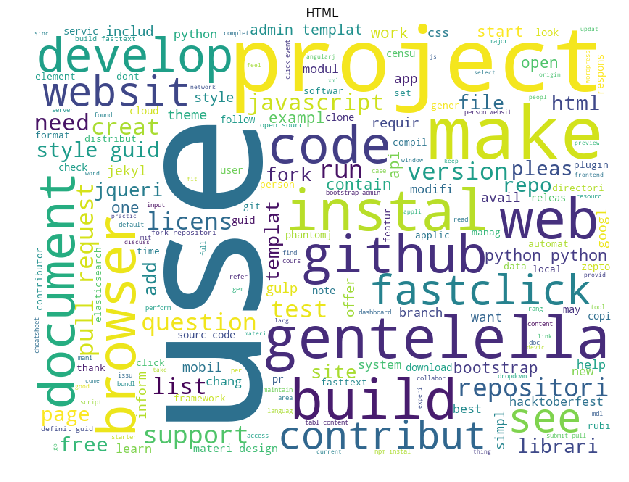

In [34]:
for lang, words in words_by_lang.items():
    plt.figure(figsize=(12, 8))
    cloud = WordCloud(
        background_color="white", height=600, width=800
    ).generate(words)
    plt.title(lang)
    plt.axis("off")
    plt.imshow(cloud)

**Conclusions**

"project", "use' are common words among the languages, but other than these, the most common words among the languages are different.

### Bigrams

**Most common bigrams and bar plot**

Other
(al, pdf)            165
(et, al)             165
(neural, network)    106
(open, sourc)         89
(theme, creat)        85
dtype: int64


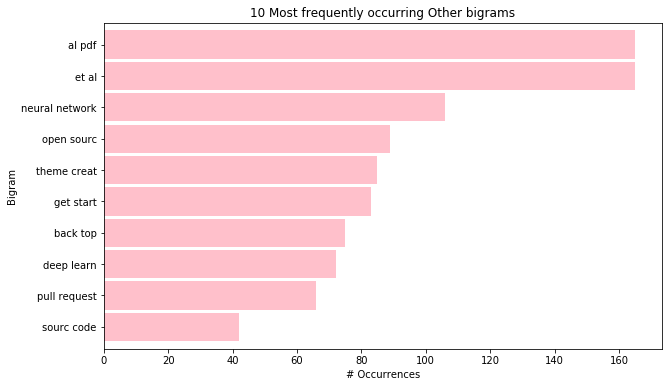

JavaScript
(get, start)     102
(npm, instal)     81
(back, top)       60
(run, test)       52
(sourc, code)     52
dtype: int64


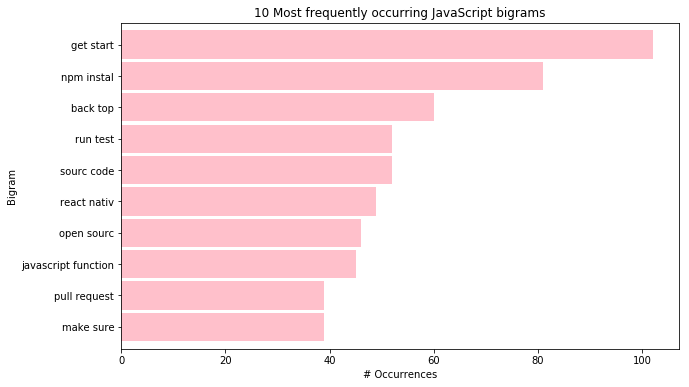

Java
(overrid, public)    23
(public, void)       21
(sourc, code)        19
(get, start)         18
(share, element)     17
dtype: int64


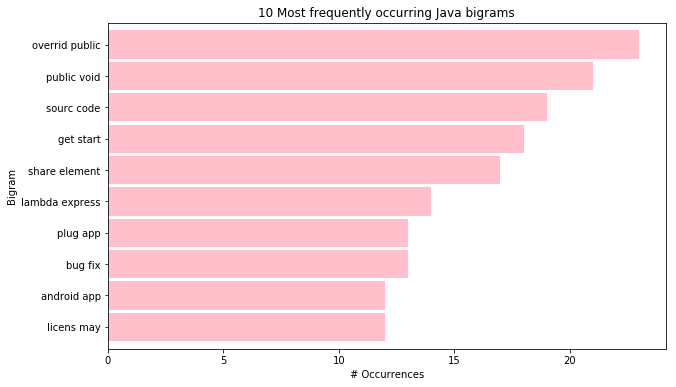

Python
(machin, learn)      112
(arxiv, preprint)     80
(neural, network)     79
(et, al)              65
(deep, learn)         45
dtype: int64


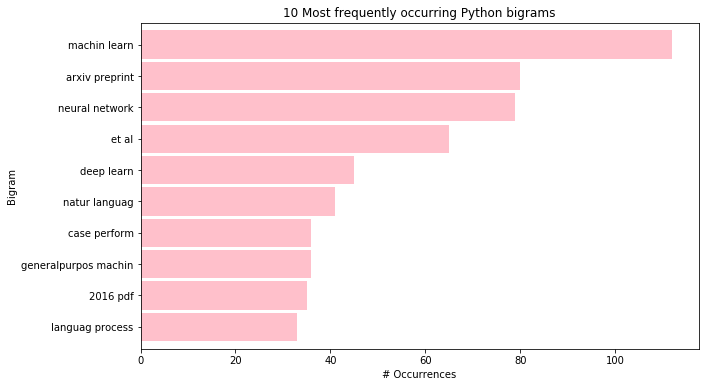

C++
(binari, tree)    17
(googl, test)     16
(deep, learn)     16
(open, sourc)     14
(ii, cmedium)     14
dtype: int64


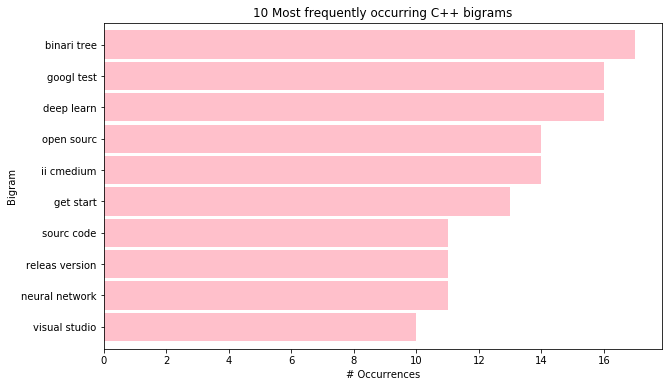

HTML
(pull, request)     16
(style, guid)       15
(admin, templat)    11
(python, python)    11
(materi, design)     8
dtype: int64


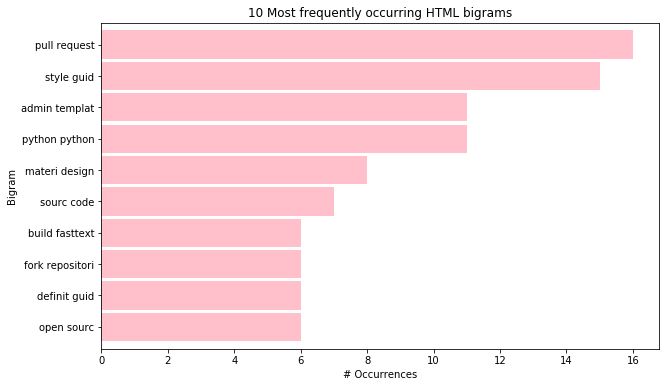

In [35]:
for lang, words in words_by_lang.items():
    bigrams = pd.Series(nltk.ngrams(words.split(), 2)).value_counts()
    print(f"{lang}\n{bigrams.head()}")

    # Bar plot the bigrams
    bigrams.sort_values().tail(10).plot.barh(
        color="pink", width=0.9, figsize=(10, 6)
    )

    plt.title(f"10 Most frequently occurring {lang} bigrams")
    plt.ylabel("Bigram")
    plt.xlabel("# Occurrences")

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = (
        bigrams.sort_values()
        .tail(10)
        .reset_index()["index"]
        .apply(lambda t: " ".join(t))
    )
    _ = plt.yticks(ticks, labels)
    plt.show()

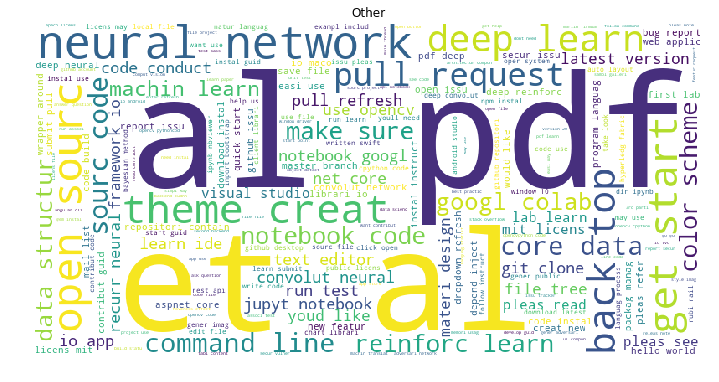

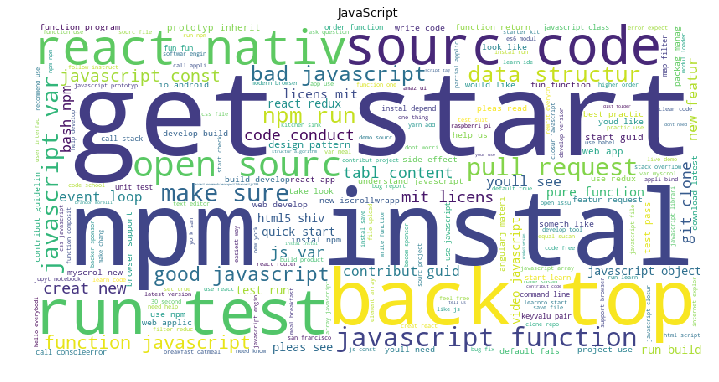

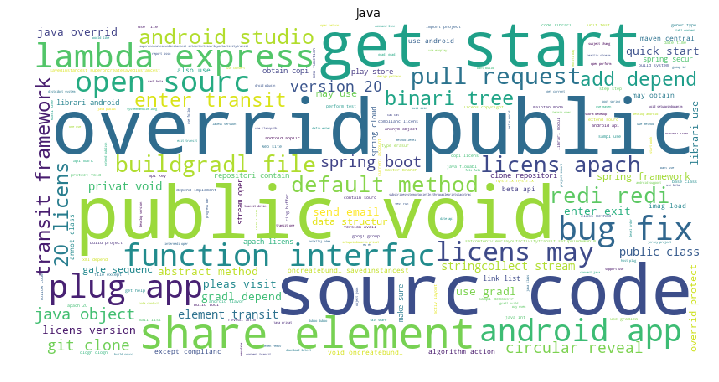

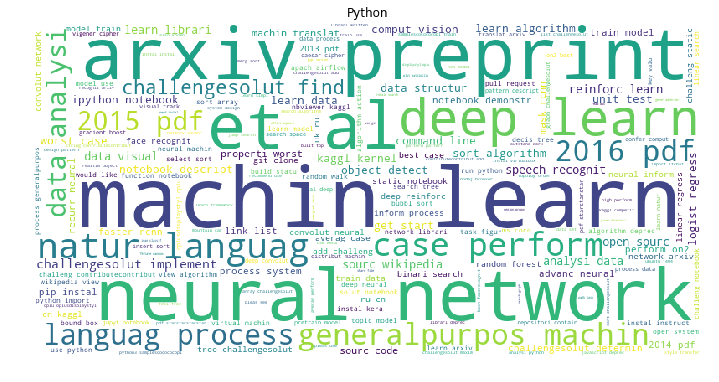

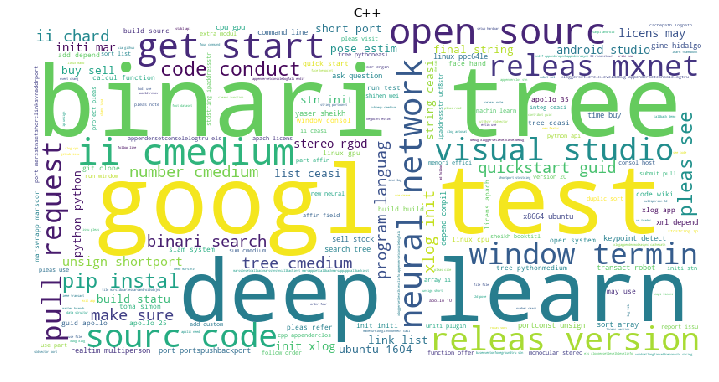

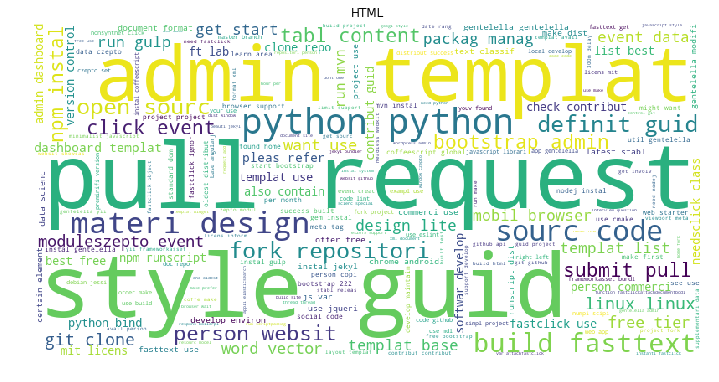

In [36]:
for lang, words in words_by_lang.items():
    bigrams = pd.Series(nltk.ngrams(words.split(), 2)).value_counts()

    # word cloud
    data = {" ".join(k): v for k, v in bigrams.to_dict().items()}
    img = WordCloud(
        background_color="white", width=800, height=400
    ).generate_from_frequencies(data)
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.title(lang)
    plt.imshow(img)

**Conclusions**

There is overlap among the languages as to the most common bigrams. The brigrams may not be that helpful after all.

### Trigram

Other
(et, al, pdf)                  160
(notebook, googl, colab)        27
(convolut, neural, network)     24
(recurr, neural, network)       21
(deep, neural, network)         18
dtype: int64


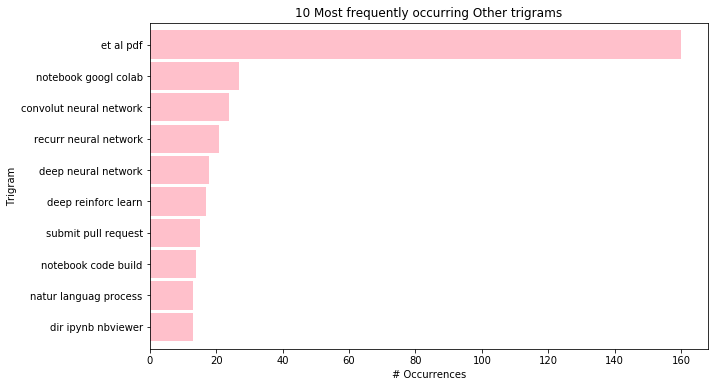

JavaScript
(bash, npm, instal)             15
(good, javascript, function)    14
(myscrol, new, iscrollwrapp)    14
(fun, fun, function)            13
(get, start, guid)              13
dtype: int64


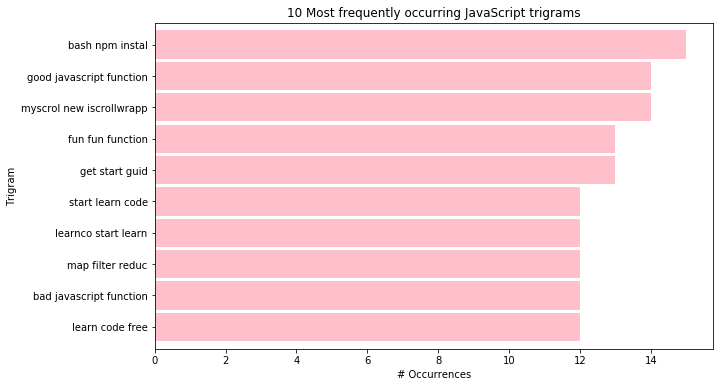

Java
(overrid, public, void)      20
(share, element, transit)     8
(licens, version, 20)         7
(redi, redi, redi)            7
(licens, may, use)            6
dtype: int64


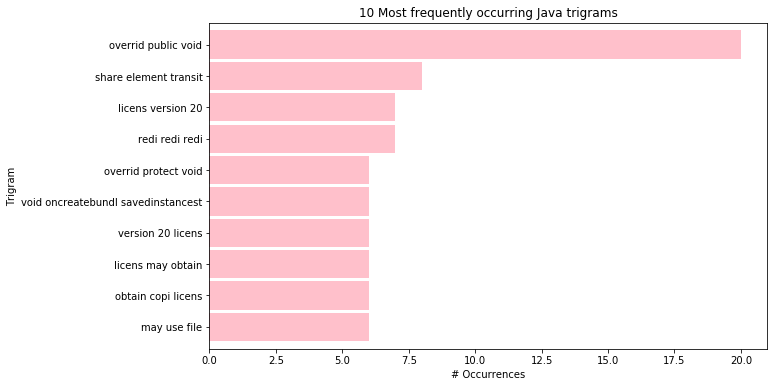

Python
(generalpurpos, machin, learn)    34
(natur, languag, process)         33
(data, analysi, data)             19
(analysi, data, visual)           18
(machin, learn, librari)          12
dtype: int64


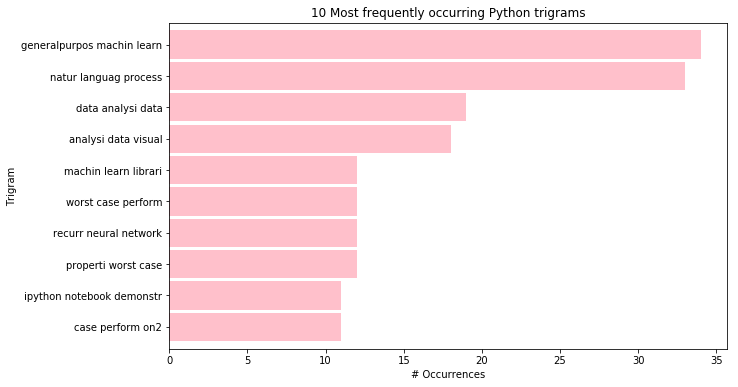

C++
(portconst, unsign, shortport)    6
(xml, depend, compil)             6
(time, buy, sell)                 6
(buy, sell, stock)                6
(quickstart, guid, apollo)        5
dtype: int64


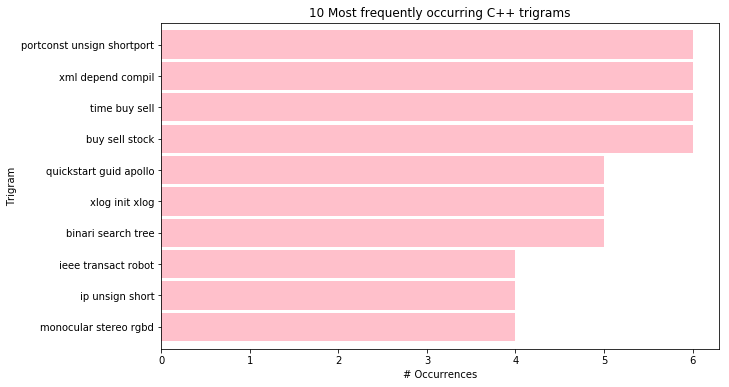

HTML
(python, python, python)       7
(submit, pull, request)        5
(bootstrap, admin, templat)    4
(moduleszepto, event, data)    4
(materi, design, lite)         4
dtype: int64


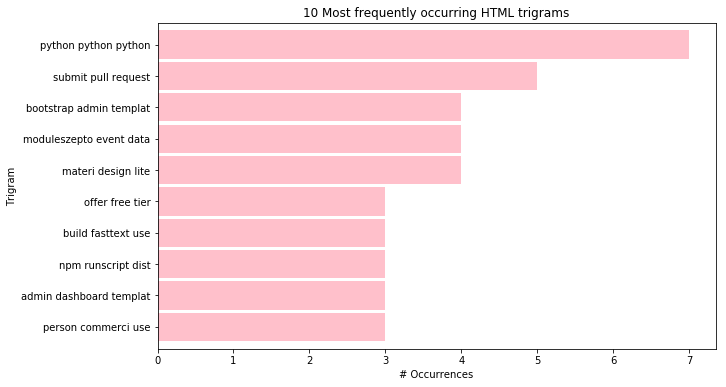

In [37]:
for lang, words in words_by_lang.items():
    trigrams = pd.Series(nltk.ngrams(words.split(), 3)).value_counts()
    print(f"{lang}\n{trigrams.head()}")

    # Bar plot the trigrams
    trigrams.sort_values().tail(10).plot.barh(
        color="pink", width=0.9, figsize=(10, 6)
    )

    plt.title(f"10 Most frequently occurring {lang} trigrams")
    plt.ylabel("Trigram")
    plt.xlabel("# Occurrences")

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = (
        trigrams.sort_values()
        .tail(10)
        .reset_index()["index"]
        .apply(lambda t: " ".join(t))
    )
    _ = plt.yticks(ticks, labels)
    plt.show()

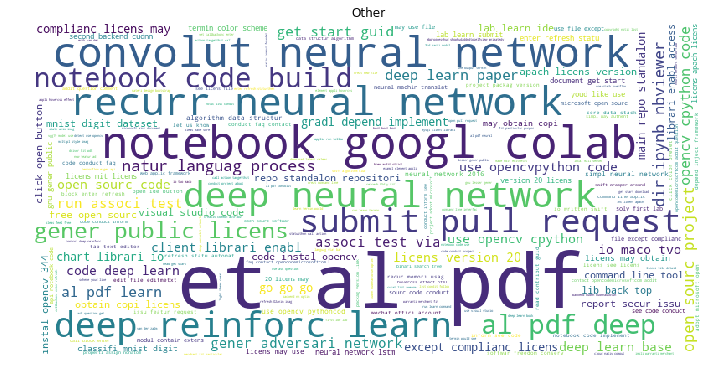

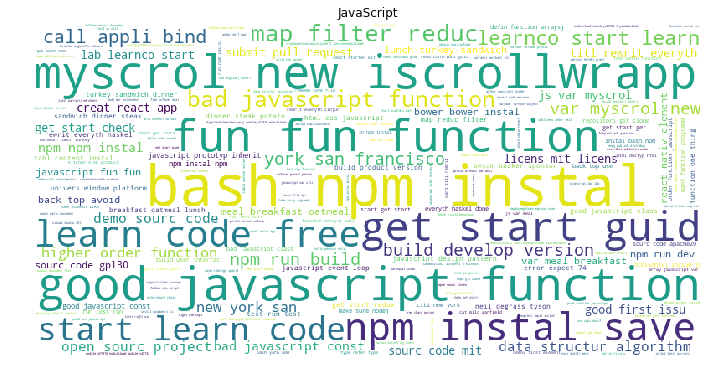

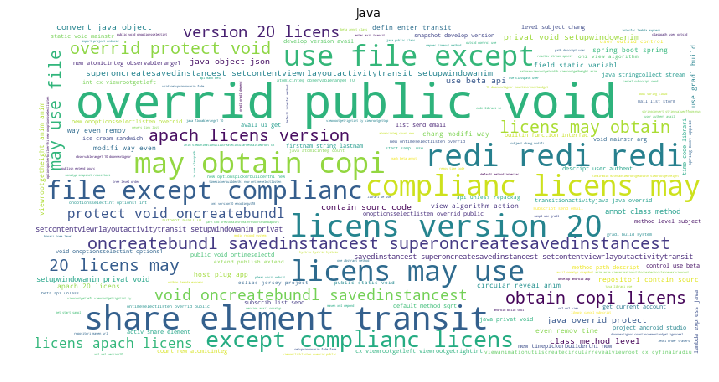

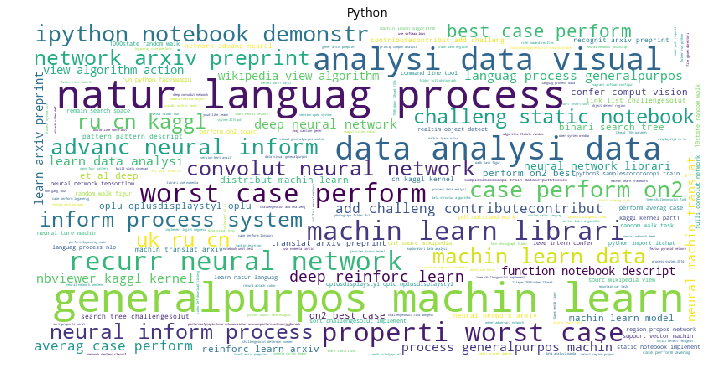

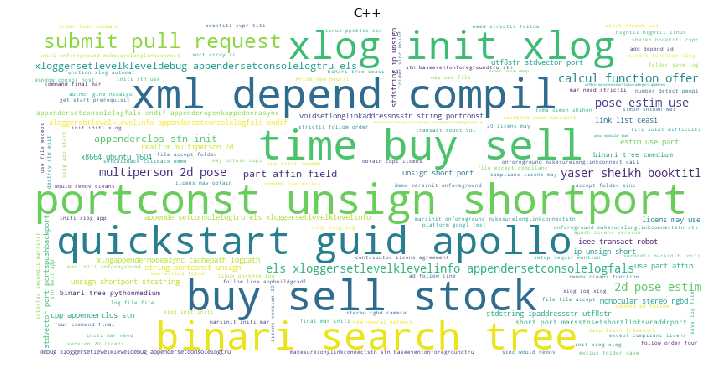

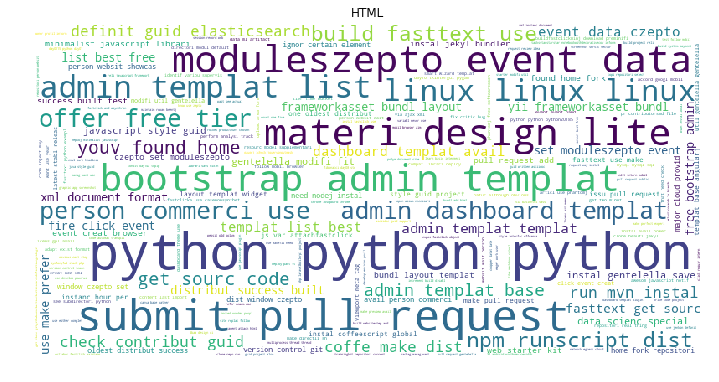

In [38]:
for lang, words in words_by_lang.items():
    trigrams = pd.Series(nltk.ngrams(words.split(), 3)).value_counts()

    # word cloud
    data = {" ".join(k): v for k, v in trigrams.to_dict().items()}
    img = WordCloud(
        background_color="white", width=800, height=400
    ).generate_from_frequencies(data)
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.title(lang)
    plt.imshow(img)

**Conclusion**


While there is less overlap of the most common trigrams than bigrams, these appear to be mostly junk or unique to a specific repo. 

### Summarize Conclusions

## Modeling <a name="modeling"></a>

In [39]:
def confmatrix(y_actual, y_pred):
    df = pd.DataFrame(dict(actual=y_actual, predicted=y_pred))
    return pd.crosstab(df.predicted, df.actual)

### Train test split

In [40]:
print("before removal", len(df))
df = df[df.lang_grouped.isin(top_five)]
print("after removal", len(df))

before removal 779
after removal 486


In [41]:
df.lang_grouped.value_counts()

JavaScript    219
Java          113
Python         75
C++            43
HTML           36
Name: lang_grouped, dtype: int64

**Clean gives better results than lemmatized or stemmed**

In [42]:
# X_train, X_test, y_train, y_test = train_test_split(
#     df.lemmatized, df.lang_grouped, stratify=df.lang_grouped, test_size=0.2, random_state=123
# )

# X_train, X_test, y_train, y_test = train_test_split(
#     df.stemmed, df.lang_grouped, stratify=df.lang_grouped, test_size=0.2, random_state=123
# )

X_train, X_test, y_train, y_test = train_test_split(
    df.clean, df.lang_grouped, stratify=df.lang_grouped, test_size=0.2, random_state=123
)

In [43]:
X_train.shape

(388,)

In [44]:
X_train.head()

282    nutshell jenkins leading opensource automation...
919    html portfolio youll create personal web page ...
359    telegram messenger android telegram messaging ...
401    android viewpagerindicator paging indicator wi...
376    streaming build system gulp automation gulp to...
Name: clean, dtype: object

In [45]:
type(X_train)

pandas.core.series.Series

### For ALL Words

### Calculate TF-IDF for each word

In [46]:
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [47]:
train_tfidf.shape

(388, 17169)

**Words with highest tf-idf**

In [48]:
df_tfidf.max().sort_values(ascending=False).head(10)

gekko             0.872070
phonegap          0.869855
edx               0.866713
redux             0.866179
bokeh             0.865558
pixijs            0.852040
v8                0.846619
deeplearning4j    0.835524
simplified        0.828153
libgdx            0.828149
dtype: float64

**Words with lowest tf-idf**

In [49]:
df_tfidf.max().sort_values(ascending=False).tail(10)

weakmaps         0.005262
szopka           0.005262
benoit           0.005262
javascriptes6    0.005262
hajdin           0.005262
intervals        0.004951
preventing       0.004943
grasp            0.004943
joseph           0.004943
rob              0.004943
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


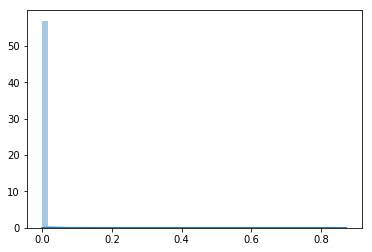

In [50]:
sns.distplot(train_tfidf.todense().flatten())

### KNN

In [51]:
def knnmodel(X_train, X_test, y_train, y_test, **kwargs):
    ks = range(1, 15)
    sse = []
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_train)

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_)

    print(pd.DataFrame(dict(k=ks, sse=sse)))

    plt.plot(ks, sse, "bx-")
    plt.xlabel("k")
    plt.ylabel("SSE")
    plt.title("The Elbow Method showing the optimal k")
    plt.show()
    
    knn = KNeighborsClassifier(**kwargs)
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_proba_train = knn.predict_proba(X_train)
    
    print("TRAIN")
    print()
    print(
        "Accuracy of KNN classifier on training set: {:.2f}".format(
        knn.score(X_train, y_train)
        )
    )
    print()
    confmatrix(y_train, y_pred_train)
    print()
    print(classification_report(y_train, y_pred_train))
    
    y_pred_test = knn.predict(X_test)
    y_pred_proba_test = knn.predict_proba(X_test)
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    print(
        "Accuracy of KNN classifier on training set: {:.2f}".format(
        knn.score(X_test, y_test)
        )
    )
    print()
    confmatrix(y_test, y_pred_test)
    print()
    print(classification_report(y_test, y_pred_test))
    
    k_range = range(1, 20)
    scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
    plt.figure()
    plt.xlabel("k")
    plt.ylabel("accuracy")
    plt.scatter(k_range, scores)
    # plt.xticks([0,5,10,15,20])
    
    return knn

     k         sse
0    1  378.808758
1    2  376.862793
2    3  373.662569
3    4  372.734781
4    5  371.685862
5    6  368.982769
6    7  367.831899
7    8  366.496277
8    9  365.040555
9   10  363.405523
10  11  361.654378
11  12  360.992362
12  13  359.431417
13  14  357.706718


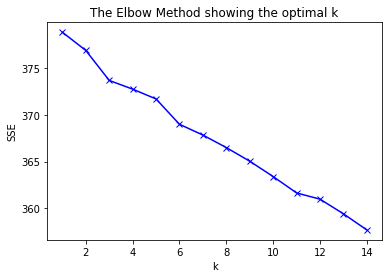

TRAIN

Accuracy of KNN classifier on training set: 0.80


              precision    recall  f1-score   support

         C++       0.88      0.44      0.59        34
        HTML       0.71      0.34      0.47        29
        Java       0.79      0.86      0.82        90
  JavaScript       0.79      0.94      0.86       175
      Python       0.83      0.72      0.77        60

   micro avg       0.80      0.80      0.80       388
   macro avg       0.80      0.66      0.70       388
weighted avg       0.80      0.80      0.78       388

--------------------

TEST

Accuracy of KNN classifier on training set: 0.71


              precision    recall  f1-score   support

         C++       0.50      0.22      0.31         9
        HTML       0.80      0.57      0.67         7
        Java       0.63      0.83      0.72        23
  JavaScript       0.79      0.86      0.83        44
      Python       0.64      0.47      0.54        15

   micro avg       0.71      0.71      0.71     

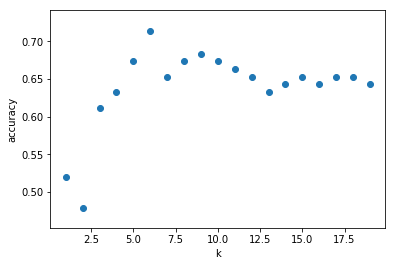

In [52]:
knn = knnmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_neighbors=6, weights="uniform")

### Naive Bayes Model

In [53]:
def nbmodel(X_train, X_test, y_train, y_test, **kwargs):
    gnb = GaussianNB(**kwargs)
    gnb.fit(X_train, y_train)
    
    print("TRAIN")
    print()
    y_pred_train = gnb.predict(X_train)
    print(
        "Accuracy of GNB classifier on training set: {:.2f}".format(
            gnb.score(X_train, y_train)
        )
    )
    print()
    print(confmatrix(y_train, y_pred_train))
    print()
    print(classification_report(y_train, y_pred_train))
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    y_pred_test = gnb.predict(X_test)
    print(
        "Accuracy of GNB classifier on training set: {:.2f}".format(
            gnb.score(X_test, y_test)
        )
    )
    print()
    print(confmatrix(y_test, y_pred_test))
    print()
    print(classification_report(y_test, y_pred_test))
    
    return gnb

In [54]:
nbmodel(train_tfidf.todense(), test_tfidf.todense(), y_train, y_test)

TRAIN

Accuracy of GNB classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     1           0       0
HTML          0    29     0           1       0
Java          0     0    89           1       0
JavaScript    0     0     0         172       0
Python        0     0     0           1      60

              precision    recall  f1-score   support

         C++       0.97      1.00      0.99        34
        HTML       0.97      1.00      0.98        29
        Java       0.99      0.99      0.99        90
  JavaScript       1.00      0.98      0.99       175
      Python       0.98      1.00      0.99        60

   micro avg       0.99      0.99      0.99       388
   macro avg       0.98      0.99      0.99       388
weighted avg       0.99      0.99      0.99       388

--------------------

TEST

Accuracy of GNB classifier on training set: 0.60

actual      C++  HTML  Java  JavaScript

GaussianNB(priors=None, var_smoothing=1e-09)

### Logistic Regression

In [55]:
def lrmodel(X_train, X_test, y_train, y_test, **kwargs):
    lm = LogisticRegression(**kwargs).fit(X_train, y_train)
    
    print("TRAIN")
    print()
    y_pred_train = lm.predict(X_train)
    print(
        "Accuracy of lm classifier on training set: {:.2f}".format(
            accuracy_score(y_train, y_pred_train)
        )
    )
    print()
    print(confmatrix(y_train, y_pred_train))
    print()
    print(classification_report(y_train, y_pred_train))
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    y_pred_test = lm.predict(X_test)
    print(
        "Accuracy of lm classifier on training set: {:.2f}".format(
            accuracy_score(y_test, y_pred_test)
        )
    )
    print()
    print(confmatrix(y_test, y_pred_test))
    print()
    print(classification_report(y_test, y_pred_test))
    
    return lm

In [56]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 1.00

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           0       0
HTML          0    29     0           0       0
Java          0     0    90           1       0
JavaScript    0     0     0         174       0
Python        0     0     0           0      60

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        34
        HTML       1.00      1.00      1.00        29
        Java       0.99      1.00      0.99        90
  JavaScript       1.00      0.99      1.00       175
      Python       1.00      1.00      1.00        60

   micro avg       1.00      1.00      1.00       388
   macro avg       1.00      1.00      1.00       388
weighted avg       1.00      1.00      1.00       388

--------------------

TEST

Accuracy of lm classifier on training set: 0.71

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

### Decision Tree

In [57]:
clf = DecisionTreeClassifier(
    criterion="entropy", max_depth=20, random_state=123, class_weight="balanced"
)

In [58]:
clf.fit(train_tfidf, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [59]:
y_pred = clf.predict(train_tfidf)
y_pred[0:5]

array(['Java', 'JavaScript', 'Java', 'Java', 'JavaScript'], dtype=object)

In [60]:
y_pred_proba = clf.predict_proba(train_tfidf)
# y_pred_proba

### Computing the accuracy of our model

In [61]:
print(
    "Accuracy of Decision Tree classifier on training set: {:.2f}".format(
        clf.score(train_tfidf, y_train)
    )
)

Accuracy of Decision Tree classifier on training set: 0.87


In [62]:
confmatrix(y_train, y_pred)

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           0       0
HTML          0    29     0           1       0
Java          0     0    73           1       0
JavaScript    0     0     0         140       0
Python        0     0    17          33      60

In [63]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        34
        HTML       0.97      1.00      0.98        29
        Java       0.99      0.81      0.89        90
  JavaScript       1.00      0.80      0.89       175
      Python       0.55      1.00      0.71        60

   micro avg       0.87      0.87      0.87       388
   macro avg       0.90      0.92      0.89       388
weighted avg       0.92      0.87      0.88       388



In [64]:
print(
    "Accuracy of Decision Tree classifier on test set: {:.2f}".format(
        clf.score(test_tfidf, y_test)
    )
)

Accuracy of Decision Tree classifier on test set: 0.54


### Random Forest

In [65]:
def rfmodel(X_train, X_test, y_train, y_test, **kwargs):
    clf = RandomForestClassifier(**kwargs).fit(X_train, y_train)
    
#     print("Feature Importances:")
#     print(clf.feature_importances_)
    print()
    print("TRAIN")
    print()
    y_pred_train = clf.predict(X_train)
    print(
        "Accuracy of clf classifier on training set: {:.2f}".format(
            accuracy_score(y_train, y_pred_train)
        )
    )
    print()
    print(confmatrix(y_train, y_pred_train))
    print()
    print(classification_report(y_train, y_pred_train))
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    y_pred_test = clf.predict(X_test)
    print(
        "Accuracy of clf classifier on training set: {:.2f}".format(
            accuracy_score(y_test, y_pred_test)
        )
    )
    print()
    print(confmatrix(y_test, y_pred_test))
    print()
    print(classification_report(y_test, y_pred_test))
    
    return clf

In [66]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=100,
    max_depth=10,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.90

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          27     0     0           0       0
HTML          0    25     0           0       0
Java          6     4    90          20       8
JavaScript    1     0     0         155       0
Python        0     0     0           0      52

              precision    recall  f1-score   support

         C++       1.00      0.79      0.89        34
        HTML       1.00      0.86      0.93        29
        Java       0.70      1.00      0.83        90
  JavaScript       0.99      0.89      0.94       175
      Python       1.00      0.87      0.93        60

   micro avg       0.90      0.90      0.90       388
   macro avg       0.94      0.88      0.90       388
weighted avg       0.93      0.90      0.90       388

--------------------

TEST

Accuracy of clf classifier on training set: 0.68

actual      C++  HTML  Java  JavaScrip

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

### Excluding frequent words

### Calculate TF-IDF for each word

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.05)
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [68]:
train_tfidf.shape

(388, 16698)

**Words with highest tf-idf**

In [69]:
df_tfidf.max().sort_values(ascending=False).head(10)

jennic        1.000000
tornado       1.000000
moved         1.000000
simplified    1.000000
hadoop        1.000000
phonegap      0.955500
edx           0.938185
redux         0.923089
bokeh         0.914838
hexo          0.907328
dtype: float64

**Words with lowest tf-idf**

In [70]:
df_tfidf.max().sort_values(ascending=False).tail(10)

315count               0.005322
numberjavaeasy         0.005322
iijava                 0.005322
numberpythonhard       0.005322
31next                 0.005322
319bulb                0.005322
318maximum             0.005322
numberspythonmedium    0.005322
316remove              0.005322
230kth                 0.005322
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


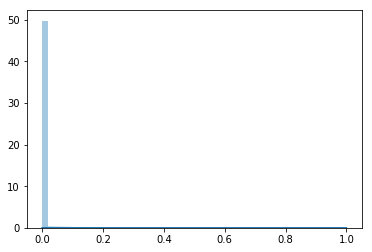

In [71]:
sns.distplot(train_tfidf.todense().flatten())

In [72]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           0       0
HTML          0    29     0           1       0
Java          0     0    90           1       0
JavaScript    0     0     0         173       0
Python        0     0     0           0      60

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        34
        HTML       0.97      1.00      0.98        29
        Java       0.99      1.00      0.99        90
  JavaScript       1.00      0.99      0.99       175
      Python       1.00      1.00      1.00        60

   micro avg       0.99      0.99      0.99       388
   macro avg       0.99      1.00      0.99       388
weighted avg       0.99      0.99      0.99       388

--------------------

TEST

Accuracy of lm classifier on training set: 0.55

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [73]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=1000,
    min_samples_leaf=3,
    max_depth=20,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.89

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          27     0     0           0       0
HTML          0    23     0           3       0
Java          5     4    90          19       7
JavaScript    1     1     0         152       1
Python        1     1     0           1      52

              precision    recall  f1-score   support

         C++       1.00      0.79      0.89        34
        HTML       0.88      0.79      0.84        29
        Java       0.72      1.00      0.84        90
  JavaScript       0.98      0.87      0.92       175
      Python       0.95      0.87      0.90        60

   micro avg       0.89      0.89      0.89       388
   macro avg       0.91      0.86      0.88       388
weighted avg       0.91      0.89      0.89       388

--------------------

TEST

Accuracy of clf classifier on training set: 0.63

actual      C++  HTML  Java  JavaScrip

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

### Excluding least frequent words

### Calculate TF-IDF for each word

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0.01)
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [75]:
with open("tfidf.obj", 'wb') as fp:
    pickle.dump(tfidf, fp)

In [76]:
train_tfidf.shape

(388, 2468)

**Words with highest tf-idf**

In [77]:
df_tfidf.max().sort_values(ascending=False).head(10)

cat         0.940245
redis       0.913808
redux       0.887040
electron    0.867025
python3     0.864110
2015        0.862493
flux        0.862205
brackets    0.857316
figure      0.856292
atom        0.851083
dtype: float64

**Words with lowest tf-idf**

In [78]:
df_tfidf.max().sort_values(ascending=False).tail(10)

declaration    0.033951
finding        0.033313
31             0.032939
imagine        0.032462
combine        0.030360
anyway         0.028362
telling        0.028362
accomplish     0.027396
mutable        0.023913
concept        0.012054
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


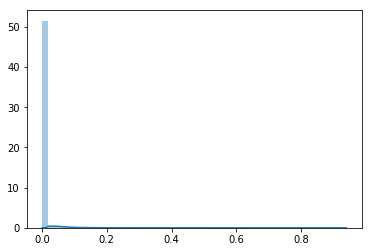

In [79]:
sns.distplot(train_tfidf.todense().flatten())

In [80]:
lm = lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.98

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     1           0       0
HTML          0    28     0           1       0
Java          0     0    88           3       0
JavaScript    0     0     1         170       0
Python        0     1     0           1      60

              precision    recall  f1-score   support

         C++       0.97      1.00      0.99        34
        HTML       0.97      0.97      0.97        29
        Java       0.97      0.98      0.97        90
  JavaScript       0.99      0.97      0.98       175
      Python       0.97      1.00      0.98        60

   micro avg       0.98      0.98      0.98       388
   macro avg       0.97      0.98      0.98       388
weighted avg       0.98      0.98      0.98       388

--------------------

TEST

Accuracy of lm classifier on training set: 0.71

actual      C++  HTML  Java  JavaScript  

In [81]:
with open("lrmodel.obj", 'wb') as fp:
    pickle.dump(lm, fp)

In [82]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=1000,
    min_samples_leaf=3,
    max_depth=20,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.95

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          33     0     0           0       0
HTML          0    27     0           0       0
Java          1     1    90          13       3
JavaScript    0     0     0         161       0
Python        0     1     0           1      57

              precision    recall  f1-score   support

         C++       1.00      0.97      0.99        34
        HTML       1.00      0.93      0.96        29
        Java       0.83      1.00      0.91        90
  JavaScript       1.00      0.92      0.96       175
      Python       0.97      0.95      0.96        60

   micro avg       0.95      0.95      0.95       388
   macro avg       0.96      0.95      0.95       388
weighted avg       0.96      0.95      0.95       388

--------------------

TEST

Accuracy of clf classifier on training set: 0.68

actual      C++  HTML  Java  JavaScrip

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

### Excluding most and least frequent words

### Calculate TF-IDF for each word

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0.01, max_df=0.05)
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [84]:
train_tfidf.shape

(388, 1997)

**Words with highest tf-idf**

In [85]:
df_tfidf.max().sort_values(ascending=False).head(10)

python3       1.0
simplified    1.0
showing       1.0
renamed       1.0
training      1.0
middleware    1.0
starter       1.0
moved         1.0
2015          1.0
exercise      1.0
dtype: float64

**Words with lowest tf-idf**

In [86]:
df_tfidf.max().sort_values(ascending=False).tail(10)

imagine        0.052034
telling        0.045061
anyway         0.045061
accomplish     0.043526
finding        0.043425
declaration    0.039342
31             0.038169
combine        0.035501
mutable        0.034781
concept        0.016761
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


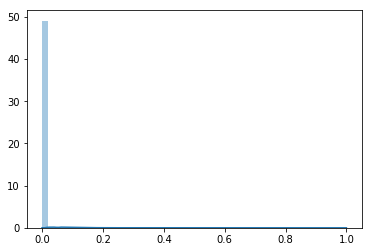

In [87]:
sns.distplot(train_tfidf.todense().flatten())

In [88]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.97

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          33     0     0           0       0
HTML          0    29     1           4       0
Java          0     0    88           2       0
JavaScript    1     0     1         167       2
Python        0     0     0           2      58

              precision    recall  f1-score   support

         C++       1.00      0.97      0.99        34
        HTML       0.85      1.00      0.92        29
        Java       0.98      0.98      0.98        90
  JavaScript       0.98      0.95      0.97       175
      Python       0.97      0.97      0.97        60

   micro avg       0.97      0.97      0.97       388
   macro avg       0.95      0.97      0.96       388
weighted avg       0.97      0.97      0.97       388

--------------------

TEST

Accuracy of lm classifier on training set: 0.59

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [89]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=100,
    max_depth=20,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.90

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          29     0     0           0       0
HTML          0    27     0           0       0
Java          0     1    73           1       0
JavaScript    5     1    17         174      12
Python        0     0     0           0      48

              precision    recall  f1-score   support

         C++       1.00      0.85      0.92        34
        HTML       1.00      0.93      0.96        29
        Java       0.97      0.81      0.88        90
  JavaScript       0.83      0.99      0.91       175
      Python       1.00      0.80      0.89        60

   micro avg       0.90      0.90      0.90       388
   macro avg       0.96      0.88      0.91       388
weighted avg       0.92      0.90      0.90       388

--------------------

TEST

Accuracy of clf classifier on training set: 0.57

actual      C++  HTML  Java  JavaScrip

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

**Conclusions**

Results are very mixed when excluding the most and/or least frequent words. Sometimes the results of the model improve and sometimes they get worse.

### Using Bigrams as features

### TF-IDF

In [90]:
TOP_NBIGRAMS = 5_000
# top_nwords = top_words.sort_values(by="all", ascending=False).head(500)
# top_nwords.index.values

### Calculate TF-IDF for each word

In [91]:
tfidf = TfidfVectorizer(
    strip_accents="unicode", max_features=TOP_NBIGRAMS, ngram_range=(2, 2)
)
# tfidf = TfidfVectorizer(
#     strip_accents="unicode", ngram_range=(2, 2)
# )
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [92]:
train_tfidf.shape

(388, 5000)

In [93]:
test_tfidf.shape

(98, 5000)

In [94]:
df_tfidf.max().sort_values(ascending=False).head(10)

live demo             1.0
tutorial beginners    1.0
official website      1.0
examples see          1.0
official site         1.0
web app               1.0
issue tracker         1.0
build status          1.0
shell docker          1.0
library based         1.0
dtype: float64

In [95]:
df_tfidf.max().sort_values(ascending=False).tail(10)

oord aaron             0.017356
without explicit       0.017356
worth reading          0.017356
processing arxiv       0.017356
sequence learning      0.017356
sequence sequence      0.017356
starstarstarstar 36    0.017356
pattern recognition    0.016234
training deep          0.009204
data neural            0.009204
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


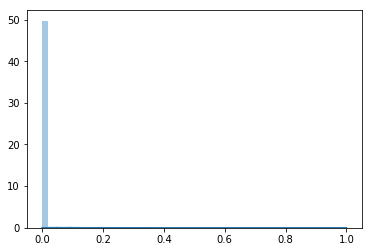

In [96]:
sns.distplot(train_tfidf.todense().flatten())

### Naive Bayes Model

In [97]:
nbmodel(train_tfidf.todense(), test_tfidf.todense(), y_train, y_test)

TRAIN

Accuracy of GNB classifier on training set: 0.91

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          32     0     1           2       0
HTML          2    29     6          13       9
Java          0     0    82           1       0
JavaScript    0     0     0         158       0
Python        0     0     1           1      51

              precision    recall  f1-score   support

         C++       0.91      0.94      0.93        34
        HTML       0.49      1.00      0.66        29
        Java       0.99      0.91      0.95        90
  JavaScript       1.00      0.90      0.95       175
      Python       0.96      0.85      0.90        60

   micro avg       0.91      0.91      0.91       388
   macro avg       0.87      0.92      0.88       388
weighted avg       0.95      0.91      0.92       388

--------------------

TEST

Accuracy of GNB classifier on training set: 0.52

actual      C++  HTML  Java  JavaScript

GaussianNB(priors=None, var_smoothing=1e-09)

### Logistic Regression

In [98]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test,
    random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced",
)

TRAIN

Accuracy of lm classifier on training set: 0.96

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          33     0     0           0       0
HTML          0    27     0           2       0
Java          0     0    87           1       0
JavaScript    1     2     3         171       7
Python        0     0     0           1      53

              precision    recall  f1-score   support

         C++       1.00      0.97      0.99        34
        HTML       0.93      0.93      0.93        29
        Java       0.99      0.97      0.98        90
  JavaScript       0.93      0.98      0.95       175
      Python       0.98      0.88      0.93        60

   micro avg       0.96      0.96      0.96       388
   macro avg       0.97      0.95      0.96       388
weighted avg       0.96      0.96      0.96       388

--------------------

TEST

Accuracy of lm classifier on training set: 0.63

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

### Random Forest

In [99]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=100, max_depth=20, random_state=123, class_weight="balanced"
)


TRAIN

Accuracy of clf classifier on training set: 0.83

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          25     0     0           0       0
HTML          0    25     0           0       0
Java          8     4    89          37      13
JavaScript    0     0     1         138       2
Python        1     0     0           0      45

              precision    recall  f1-score   support

         C++       1.00      0.74      0.85        34
        HTML       1.00      0.86      0.93        29
        Java       0.59      0.99      0.74        90
  JavaScript       0.98      0.79      0.87       175
      Python       0.98      0.75      0.85        60

   micro avg       0.83      0.83      0.83       388
   macro avg       0.91      0.82      0.85       388
weighted avg       0.89      0.83      0.84       388

--------------------

TEST

Accuracy of clf classifier on training set: 0.50

actual      C++  HTML  Java  JavaScrip

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

### Bag of Words

In [100]:
vectorizer = CountVectorizer(max_features=750)
train_bow = vectorizer.fit_transform(X_train)
test_bow = vectorizer.transform(X_test)

df_bow = pd.DataFrame(train_bow.todense(), columns=vectorizer.get_feature_names())

In [101]:
train_bow.shape

(388, 750)

**Most common wordsf**

In [102]:
df_bow.sum().sort_values(ascending=False).head(10)

javascript    758
use           596
code          497
using         435
new           386
data          346
see           319
project       311
learning      295
install       282
dtype: int64

**Least common words**

In [103]:
df_bow.sum().sort_values(ascending=False).tail(10)

known          23
bar            23
2018           23
reading        23
cloud          23
think          23
move           23
11             23
box            23
lightweight    23
dtype: int64

In [104]:
nbmodel(train_bow.todense(), test_bow.todense(), y_train, y_test)

TRAIN

Accuracy of GNB classifier on training set: 0.76

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          32     0    13          10      13
HTML          2    29    10          17       5
Java          0     0    67          17       1
JavaScript    0     0     0         126       0
Python        0     0     0           5      41

              precision    recall  f1-score   support

         C++       0.47      0.94      0.63        34
        HTML       0.46      1.00      0.63        29
        Java       0.79      0.74      0.77        90
  JavaScript       1.00      0.72      0.84       175
      Python       0.89      0.68      0.77        60

   micro avg       0.76      0.76      0.76       388
   macro avg       0.72      0.82      0.73       388
weighted avg       0.85      0.76      0.78       388

--------------------

TEST

Accuracy of GNB classifier on training set: 0.49

actual      C++  HTML  Java  JavaScript

GaussianNB(priors=None, var_smoothing=1e-09)

In [105]:
lrmodel(train_bow, test_bow, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           0       0
HTML          0    29     0           0       0
Java          0     0    89           1       0
JavaScript    0     0     0         173       0
Python        0     0     1           1      60

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        34
        HTML       1.00      1.00      1.00        29
        Java       0.99      0.99      0.99        90
  JavaScript       1.00      0.99      0.99       175
      Python       0.97      1.00      0.98        60

   micro avg       0.99      0.99      0.99       388
   macro avg       0.99      1.00      0.99       388
weighted avg       0.99      0.99      0.99       388

--------------------

TEST

Accuracy of lm classifier on training set: 0.63

actual      C++  HTML  Java  JavaScript  

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [106]:
rfmodel(train_bow, test_bow, y_train, y_test,
    n_estimators=200, max_depth=10, random_state=123, class_weight="balanced"
)


TRAIN

Accuracy of clf classifier on training set: 0.93

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          29     0     0           0       0
HTML          0    26     0           1       0
Java          3     2    90          16       4
JavaScript    1     0     0         158       0
Python        1     1     0           0      56

              precision    recall  f1-score   support

         C++       1.00      0.85      0.92        34
        HTML       0.96      0.90      0.93        29
        Java       0.78      1.00      0.88        90
  JavaScript       0.99      0.90      0.95       175
      Python       0.97      0.93      0.95        60

   micro avg       0.93      0.93      0.93       388
   macro avg       0.94      0.92      0.92       388
weighted avg       0.94      0.93      0.93       388

--------------------

TEST

Accuracy of clf classifier on training set: 0.71

actual      C++  HTML  Java  JavaScrip

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)

**Conclusions**

For the most part, bag of words performs worse than TF-IDF, except for the random forest model.